# Распарсить базу новостей, решить задачу NER

In [ ]:
import numpy as np
from tensorflow.keras.layers import Dense,  Input, concatenate, LSTM, GRU, Embedding, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import io
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Подготовка данных

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
color_meaning = {'00ff00':'сравнение', '00ffff':'дальность', '9900ff':'эмоции', 'ff00ff':'комфорт', 'ffff00':'скорость',
                'green':'сравнение', 'yellow':'скорость', 'cyan':'дальность', 'magenta':'комфорт'}
meaning_token = {'сравнение':0, 'дальность':1, 'эмоции':2, 'комфорт':3, 'скорость':4}
token_meaning = {value:key for key, value in meaning_token.items()}

In [ ]:
#названия необходимых тегов
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

In [ ]:
#парсим tesla_2
tree = ET.parse('tesla_2.xml') #открываем xml файл
root = tree.getroot() #находим корень
body = root[0]
ps2 = list(iter(body))[:2481] #получаем список всех отзывов

In [ ]:
x2 = []
y2 = []

for i, paragraph in enumerate(ps2): #проходим по всем отзывам
    phrases_list = paragraph.findall(r) #находим все фразы (часть отзыва)
    text='' #заготовка под текст
    labels = [0, 0, 0, 0, 0] #заготовка под разметку
    for phrase in phrases_list: #проходим по всем фразам
        text += phrase.find(t).text #получаем текст, содержащийся во фразе
        style = phrase.find(rpr) #получаем стили фразы
        
        if style.find(shd) is not None: #если размечали через заливку
            color = style.find(shd).attrib[fill] #получаем значение цвета заливки
        elif style.find(highlight) is not None: #если размечали через хайлайт
            color = style.find(highlight).attrib[val] #получаем значение цвета хайлайта
        else:
            color = 'white' #иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
        color = color.lower() #переводим строковое значение цвета в нижний регистр
        meaning = color_meaning[color] if color in color_meaning else '' #если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
        
        if meaning in meaning_token: #если во фразе есть какая-то семантическая(смысловая) окраска
          labels[meaning_token[meaning]] = 1 #получаем индекс позиции, соответствующей какой-то семантической(смысловой) окраске и устанавливаем по этому индексу 1
    
    x2.append(text)
    y2.append(labels)

In [ ]:
#парсим tesla_1
tree = ET.parse('tesla_1.xml') #открываем xml файл
root = tree.getroot() #находим корень
body = root[0]
ps1 = list(iter(body))[:2497] #получаем список всех отзывов

In [ ]:
x1 = []
y1 = []

for i, paragraph in enumerate(ps1): #проходим по всем отзывам
    phrases_list = paragraph.findall(r) #находим все фразы (часть отзыва)
    text='' #заготовка под текст
    labels = [0, 0, 0, 0, 0] #заготовка под разметку
    for phrase in phrases_list: #проходим по всем фразам
        text += phrase.find(t).text #получаем текст, содержащийся во фразе
        style = phrase.find(rpr) #получаем стили фразы
        
        if style.find(shd) is not None: #если размечали через заливку
            color = style.find(shd).attrib[fill] #получаем значение цвета заливки
        elif style.find(highlight) is not None: #если размечали через хайлайт
            color = style.find(highlight).attrib[val] #получаем значение цвета хайлайта
        else:
            color = 'white' #иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
        color = color.lower() #переводим строковое значение цвета в нижний регистр
        meaning = color_meaning[color] if color in color_meaning else '' #если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
        
        if meaning in meaning_token: #если во фразе есть какая-то семантическая(смысловая) окраска
          labels[meaning_token[meaning]] = 1 #получаем индекс позиции, соответствующей какой-то семантической(смысловой) окраске и устанавливаем по этому индексу 1
    
    x1.append(text)
    y1.append(labels)

In [ ]:
n = 102
x2[n], y2[n]


('+ Чудесный автомобиль! Концепция бесплатного топлива, чистой энергетики, быстрой езды, научной сингулярности - все это относится к Tesla Model S. Автомобиль оснащен новейшим программным обеспечением в котором может разобраться человек отдаленный от использование современных девайсов.',
 [0, 0, 1, 1, 1])

In [ ]:
X = x1+x2 #объединяем результаты парсинга двух файлов в один список
Y = y1+y2

In [ ]:
len(X), len(Y)

(4978, 4978)

In [ ]:
#анализ длин предложений содержится в разборе 1 дз
num_words = 10000
sent_len = 50
tokenizer = Tokenizer(num_words, oov_token='<UNK>')
tokenizer.fit_on_texts(X)

In [ ]:
tokenizer.index_word

{1: '<UNK>',
 2: 'и',
 3: 'в',
 4: 'не',
 5: 'на',
 6: 'что',
 7: 'это',
 8: 'с',
 9: 'а',
 10: 'как',
 11: 'тесла',
 12: 'за',
 13: 'но',
 14: 'у',
 15: 'то',
 16: 'для',
 17: 'по',
 18: 'я',
 19: 'машина',
 20: 'все',
 21: 'очень',
 22: 'если',
 23: 'так',
 24: 'будет',
 25: 'бы',
 26: 'tesla',
 27: 'же',
 28: 'авто',
 29: 'только',
 30: 'теслы',
 31: 'от',
 32: 'нет',
 33: 'из',
 34: 'к',
 35: 'при',
 36: 'просто',
 37: 'уже',
 38: 'когда',
 39: 'есть',
 40: 'можно',
 41: 'до',
 42: 'она',
 43: 'автомобиль',
 44: 'model',
 45: 'вот',
 46: 'или',
 47: 'теслу',
 48: '3',
 49: 'будущее',
 50: 'мне',
 51: 'да',
 52: 'даже',
 53: 'км',
 54: '—',
 55: '\xa0',
 56: 's',
 57: 'пока',
 58: 'они',
 59: 'еще',
 60: 'чем',
 61: 'машины',
 62: 'меня',
 63: 'больше',
 64: 'ну',
 65: 'надо',
 66: 'может',
 67: 'конечно',
 68: '2',
 69: 'вы',
 70: 'тесле',
 71: 'он',
 72: 'о',
 73: 'без',
 74: '5',
 75: 'стоит',
 76: 'машину',
 77: 'двс',
 78: 'вообще',
 79: 'лет',
 80: 'всё',
 81: 'россии',
 82: '

In [ ]:
X = tokenizer.texts_to_sequences(X) #преобразуем текст в последовательность токенов
X = pad_sequences(X, sent_len, padding='post', truncating='post') #дополняем padding'ом или обрезаем до нужной длины

In [ ]:
X[:5]

array([[ 771, 6356,   31,  272,   28,    2,  772,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 345,   19,   86,  242,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  11,  403, 3866,   31,  160,  539,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [ ]:
Y = np.array(Y)

In [ ]:
Y[:5]

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1]])

In [ ]:
X.shape, Y.shape

((4978, 50), (4978, 5))

#Балансировка

(array([3159.,    0.,  581.,    0.,   70.,    0.,    5.,    0.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 8 Patch objects>)

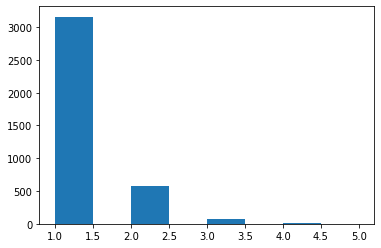

In [ ]:
#посмотрим, сколько в среднем разынх семантически-окрашенных фраз
num_labels = Y.sum(axis=1)
plt.hist(num_labels, bins=np.arange(1,5.5,0.5))

In [ ]:
for meaning in meaning_token:
  token = meaning_token[meaning]
  print('Доля предложений в общей выборке, содержащих '+meaning+':',(Y[:, token]==1).mean())

Доля предложений в общей выборке, содержащих сравнение: 0.13680192848533548
Доля предложений в общей выборке, содержащих дальность: 0.022699879469666534
Доля предложений в общей выборке, содержащих эмоции: 0.3551627159501808
Доля предложений в общей выборке, содержащих комфорт: 0.3662113298513459
Доля предложений в общей выборке, содержащих скорость: 0.03334672559260747


In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, shuffle=True) #перемешаем данные и разобьем их на тренировочную и тестовую выборки

In [ ]:
for meaning in meaning_token:
  token = meaning_token[meaning]
  print('Доля предложений в тренировочной выборке, содержащих '+meaning+':',(Ytrain[:, token]==1).mean())

Доля предложений в тренировочной выборке, содержащих сравнение: 0.13812154696132597
Доля предложений в тренировочной выборке, содержащих дальность: 0.023606228026117528
Доля предложений в тренировочной выборке, содержащих эмоции: 0.35409342039176295
Доля предложений в тренировочной выборке, содержащих комфорт: 0.36966348568558516
Доля предложений в тренировочной выборке, содержащих скорость: 0.03314917127071823


In [ ]:
one_class_only = np.zeros(5)
for meaning in meaning_token:
  token = meaning_token[meaning]
  one_class_only[token] = (Ytrain==to_categorical(token, 5)).all(1).mean()
  print('Доля предложений в тренировочной выборке, содержащих только'+meaning+':', one_class_only[token])

Доля предложений в тренировочной выборке, содержащих толькосравнение: 0.08437970868910095
Доля предложений в тренировочной выборке, содержащих толькодальность: 0.013812154696132596
Доля предложений в тренировочной выборке, содержащих толькоэмоции: 0.25816172777498747
Доля предложений в тренировочной выборке, содержащих толькокомфорт: 0.26519337016574585
Доля предложений в тренировочной выборке, содержащих толькоскорость: 0.014314414866901055


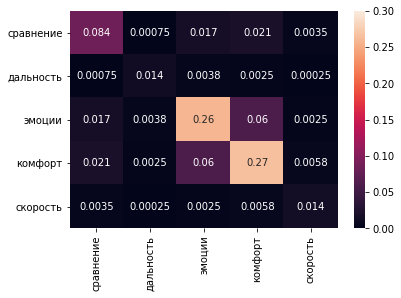

In [ ]:
#выведем долю предложений с ровно двумя смысловыми окрасками
two_classes = np.zeros((5,5))
for i in range(5):
    for j in range(5):
      label = np.array([0,0,0,0,0])
      label[[i,j]]=1
      two_classes[i,j] = (Ytrain==label).all(1).mean()
sns.heatmap(two_classes, annot=True, vmin=0, vmax=0.3, xticklabels=[token_meaning[i] for i in sorted(token_meaning)], yticklabels=[token_meaning[i] for i in sorted(token_meaning)])
#значения по диагонали должны совпадать со значениями предыдущей ячейки

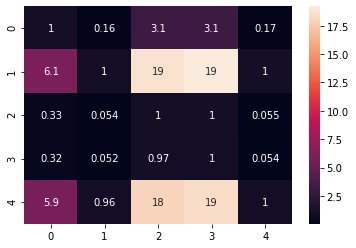

In [ ]:
#выведем таблицу кратности размеров чистых классов. число на пересечении 1 и 2 оси означает во сколько раз нужно увеличить 1 класс, чтобы он стал равен по размеру с 2 классом
#например, берем по первой оси 1 класс, по второй оси 0 класс. на пересечении 6.2 Значит, 1 класс надо увеличить в 6.2 раза, тогда он станет равным по размеру с 0 классом
multiplicity = one_class_only[None].T/one_class_only
sns.heatmap(multiplicity.T, annot=True, cmap=None)

Сама балансировка

In [ ]:
mask0 = (Ytrain[:, [0,2,3]] == [1,0,0]).all(axis=1)
mask1 = (Ytrain[:, [1,2,3]] == [1,0,0]).all(axis=1)
#классы эмоции и комфорта не балансируем
mask4 = (Ytrain[:, [4,2,3]] == [1,0,0]).all(axis=1)

In [ ]:
x_0 = np.repeat(Xtrain[mask0], repeats = 2, axis=0)
y_0 = np.repeat(Ytrain[mask0], repeats = 2, axis=0)

x_1 = np.repeat(Xtrain[mask1], repeats = 23, axis=0)
y_1 = np.repeat(Ytrain[mask1], repeats = 23, axis=0)

x_4 = np.repeat(Xtrain[mask4], repeats = 18, axis=0)
y_4 = np.repeat(Ytrain[mask4], repeats = 18, axis=0)

In [ ]:
Xtrain_balanced = np.concatenate([Xtrain, x_0, x_1, x_4])
Ytrain_balanced = np.concatenate([Ytrain, y_0, y_1, y_4])

Посмотрим на сбалансированные данные

In [ ]:
for meaning in meaning_token:
  token = meaning_token[meaning]
  print('Доля предложений в сбалансированной выборке, содержащих '+meaning+':',(Ytrain_balanced[:, token]==1).mean())

Доля предложений в сбалансированной выборке, содержащих сравнение: 0.21482086909140444
Доля предложений в сбалансированной выборке, содержащих дальность: 0.2009263043182128
Доля предложений в сбалансированной выборке, содержащих эмоции: 0.19207192480588475
Доля предложений в сбалансированной выборке, содержащих комфорт: 0.20051764064841301
Доля предложений в сбалансированной выборке, содержащих скорость: 0.20147118921127913


#Создание модели

In [ ]:
emb_size = 100 #размер скрытого пространства эмбеддинга
hidden_state_1 = 50 #размер скрытого пространства первого rnn слоя
hidden_state_2 = 50 #размер скрытого пространства второго rnn слоя

input = Input((None,))
emb = Embedding(num_words, emb_size)(input)
x = SpatialDropout1D(0.2)(emb)
x = BatchNormalization()(x)
x = Bidirectional(GRU(hidden_state_1, return_sequences=True))(x)
x = GRU(hidden_state_2)(x)
output = Dense(5, activation='sigmoid')(x)

model = Model(input, output)

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['AUC'], optimizer=Adam(learning_rate=1e-4)) #используем метрику AUC

In [ ]:
model.fit(Xtrain_balanced, Ytrain_balanced, validation_data=(Xtest, Ytest), batch_size=64, epochs=5)

Epoch 1/5
117/117 [==============================] - 4s 31ms/step - loss: 0.1617 - auc: 0.9822 - val_loss: 0.4217 - val_auc: 0.8288
Epoch 2/5
117/117 [==============================] - 4s 31ms/step - loss: 0.1579 - auc: 0.9825 - val_loss: 0.4208 - val_auc: 0.8300
Epoch 3/5
117/117 [==============================] - 4s 31ms/step - loss: 0.1561 - auc: 0.9829 - val_loss: 0.4222 - val_auc: 0.8292
Epoch 4/5
117/117 [==============================] - 4s 31ms/step - loss: 0.1541 - auc: 0.9829 - val_loss: 0.4246 - val_auc: 0.8291
Epoch 5/5
117/117 [==============================] - 4s 31ms/step - loss: 0.1512 - auc: 0.9841 - val_loss: 0.4254 - val_auc: 0.8299


#Проверка качества работы

In [ ]:
Xtest.shape

(996, 20)

In [ ]:
Y_hat = model.predict(Xtest)
Y_hat.shape, Ytest.shape

((996, 5), (996, 5))

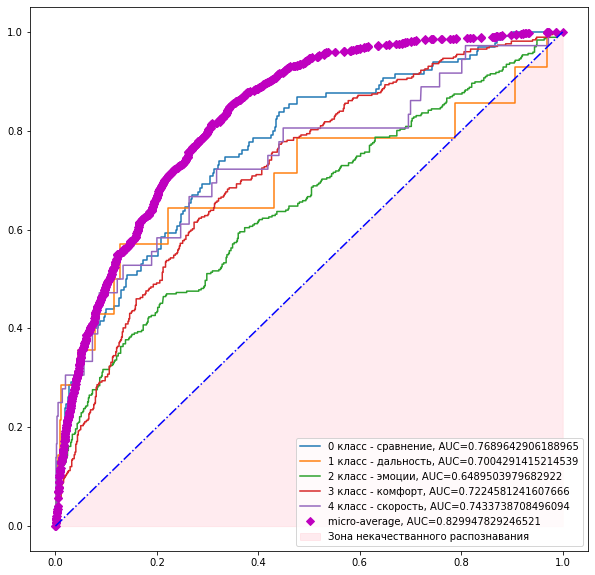

In [ ]:
plt.figure(figsize=(10,10))


num_classes = len(meaning_token) #узнаем, сколько всего классов
for i in range(num_classes): #проходимся по всем классам
  fpr, tpr, thresholds = roc_curve(Ytest[:, i], Y_hat[:, i]) #получаем roc-кривую для очередного класа
  plt.plot(fpr, tpr, label='{} класс - {}, AUC={}'.format(i, token_meaning[i], AUC()(Ytest[:, i], Y_hat[:, i]))) #отрисовываем кривую и подписываем ее площадь

avg_fpr, avg_tpr, thresholds = roc_curve(Ytest.flatten(), Y_hat.flatten()) #получаем micro-average (общую) кривую roc
plt.plot(avg_fpr, avg_tpr, 'mD',label='micro-average, AUC={}'.format(AUC()(Ytest, Y_hat)))#отрисовываем кривую и подписываем ее площадь
plt.plot([0,1], [0,1], 'b-.') #обозначим границу качественной работы нейросети
plt.fill_between([0,1], [0,1], label='Зона некачестванного распознавания', color='pink', alpha=0.3) #обозначим границу некачественной работы нейросети
plt.legend()

In [ ]:
n = 99
print(tokenizer.sequences_to_texts(Xtest[n:n+1]))
print((Y_hat[n]>=0.5).astype(int))
print(Ytest[n])

['<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> тесла очень крутая машина если ее можно так назвать']
[0 0 1 1 0]
[0 0 1 0 0]
